<a href="https://colab.research.google.com/github/nisargbm/ACPS/blob/master/PayeeName_Recognition_BiLST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')
#%cd..
#%cd ..
#!pwd

#%cd..
#%cd ..
#!pwd


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
!pip install mxnet
!pip install mxboard
!pip install gluonnlp
%cd gdrive/My Drive/HandwrittenTextRecognition_MXNet-master2

/content/gdrive/My Drive/HandwrittenTextRecognition_MXNet-master2


In [0]:

import difflib
import math
import random
import string
#random.seed(123)

import gluonnlp
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import mxnet as mx
import numpy as np
from skimage import transform as skimage_tf
from utils.iam_dataset import IAMDataset, resize_image, crop_image, crop_handwriting_page
from tqdm import tqdm
from utils.expand_bounding_box import expand_bounding_box
from utils.sclite_helper import Sclite_helper
from utils.word_to_line import sort_bbs_line_by_line, crop_line_images

from paragraph_segmentation_dcnn import make_cnn as ParagraphSegmentationNet, paragraph_segmentation_transform
from word_segmentation import SSD as WordSegmentationNet, predict_bounding_boxes
from handwriting_line_recognition import Network as HandwritingRecognitionNet, handwriting_recognition_transform
from handwriting_line_recognition import decode as decoder_handwriting, alphabet_encoding
import glob
import cv2

In [0]:
ctx = mx.cpu()

[[0.01029147 0.14481258 0.72147387 0.5664566 ]
 [0.01872157 0.42897174 0.98309105 0.6356306 ]]
[[255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 ...
 [254 254 254 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]]


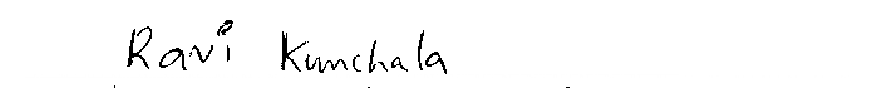

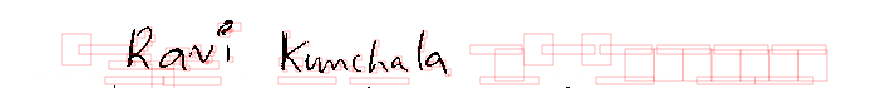

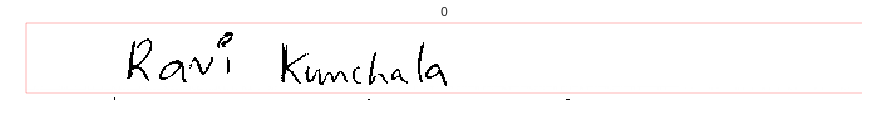

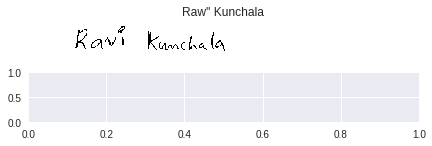

[[ 0.28975872 -0.00993986  0.00291148  0.05838452]
 [ 0.24736368  0.05060809  0.05611565  0.10416701]
 [ 0.46670957  0.85177485  0.58138326  0.10482291]]
[[255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 ...
 [254 254 254 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]]


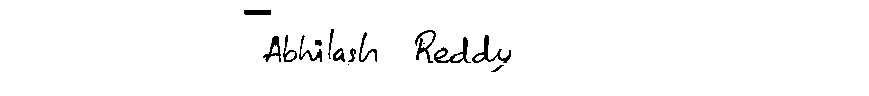

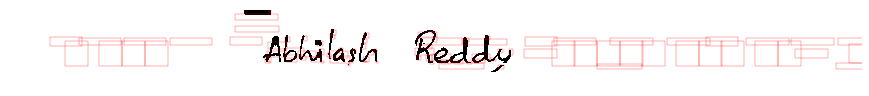

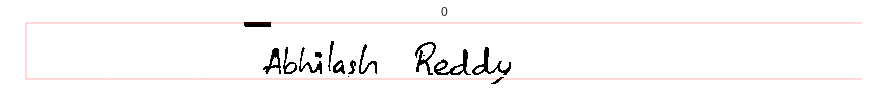

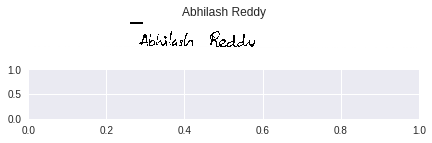

[[-0.02329002 -0.05800292  1.07332044  0.31533131]
 [-0.0393133   0.01638718  0.8720945   1.05760168]]
[[255 255 255 ...   0   0   0]
 [255 255 255 ...   0   0 255]
 [255 255 255 ... 255 255 255]
 ...
 [255 255 255 ... 254 254 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]]


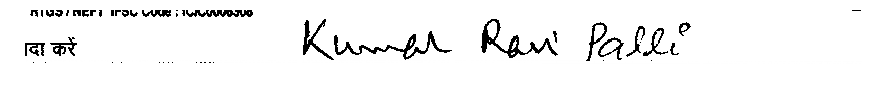

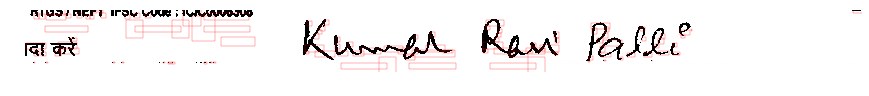

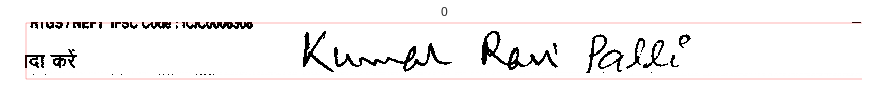

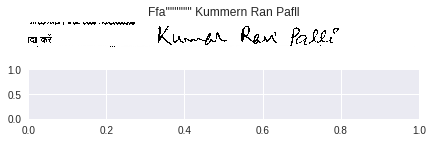

[[-0.01654145  0.38113483  1.02569093  0.2654751 ]
 [-0.01654145  0.64660993  1.02569093  0.2654751 ]
 [-0.01556066  0.85558526  0.92318349  0.09619114]]
[[255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 ...
 [255 254 254 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]]


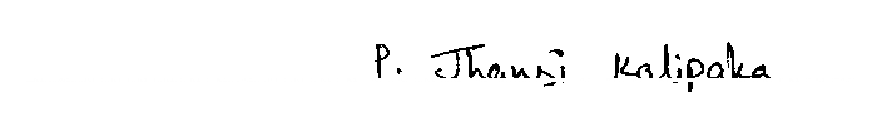

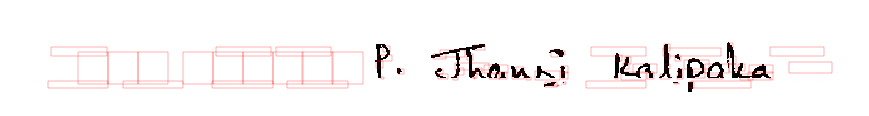

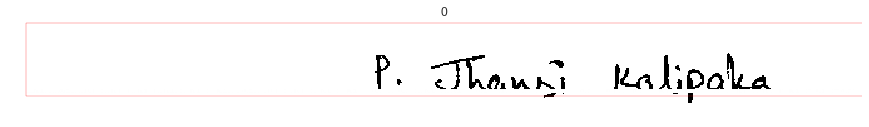

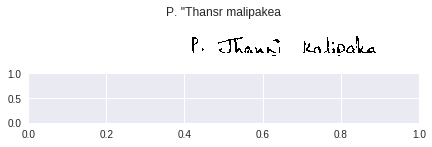

[[0.03903008 0.3789139  0.95593116 0.37073119]
 [0.03903008 0.74964508 0.95593116 0.37073119]
 [0.02771544 0.85528869 0.90577182 0.09662316]]
[[255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 ...
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]]


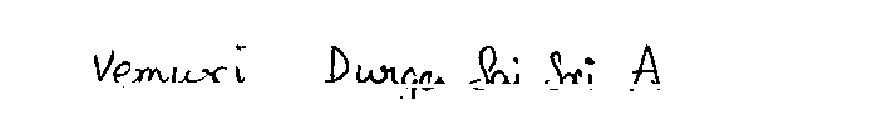

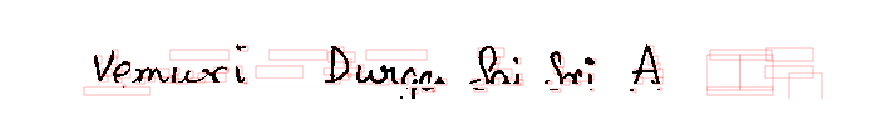

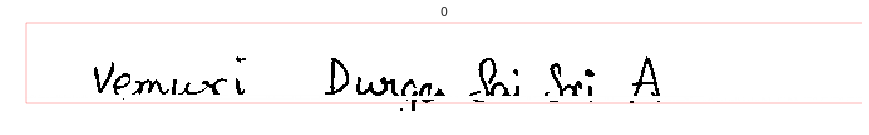

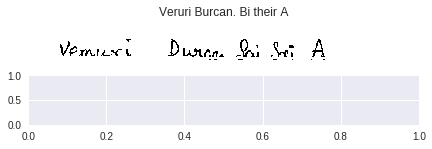

[[0.12251475 0.29153323 0.25274963 0.10434051]
 [0.08978789 0.37641894 0.85028827 0.26753614]
 [0.08978789 0.64395508 0.85028827 0.26753614]
 [0.12430287 0.85273891 0.68776613 0.09910465]]
[[255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 ...
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]]


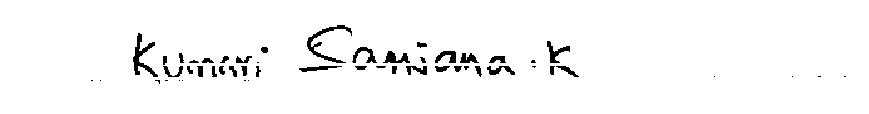

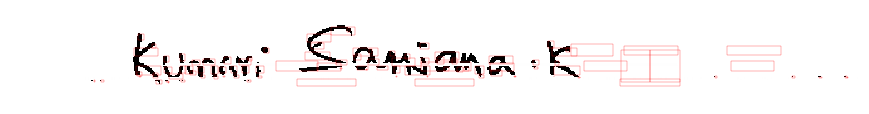

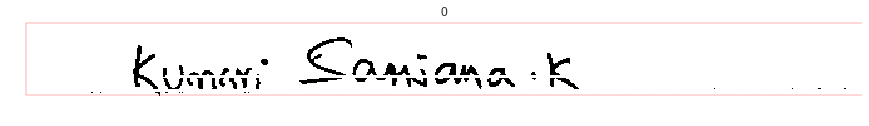

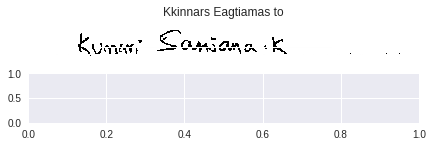

[[0.00179099 0.29838423 1.07675573 0.41285604]
 [0.00179099 0.71124026 1.07675573 0.41285604]]
[[255 255 255 ...   0   0   0]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 ...
 [255 255 255 ... 255 255 255]
 [254 254 254 ... 255 255 255]
 [255 255 255 ... 255 255 255]]


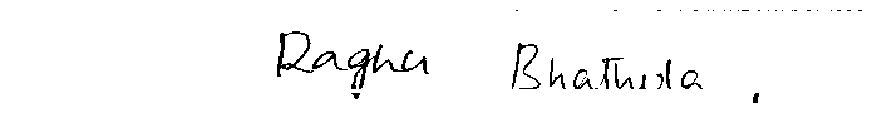

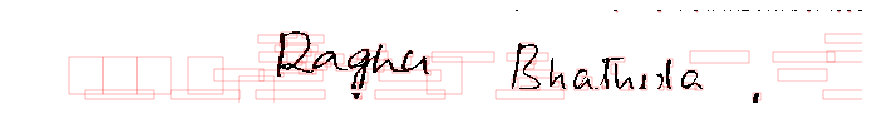

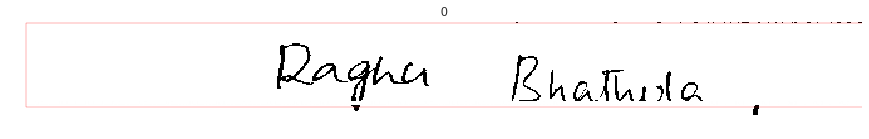

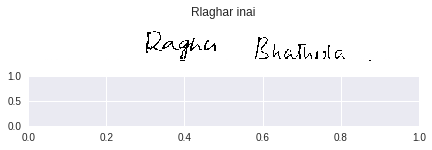

[[-0.04806637  0.36376837  1.0641511   0.35205489]
 [-0.04806637  0.71582326  1.0641511   0.35205489]]
[[255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 ...
 [255 255 255 ... 255 255 254]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]]


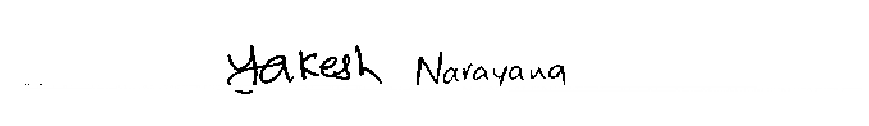

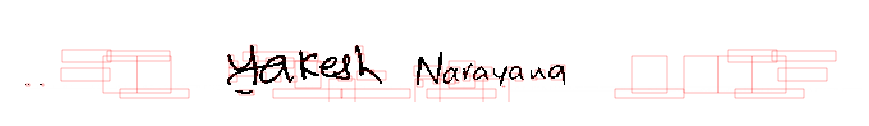

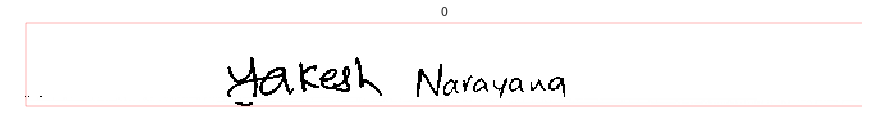

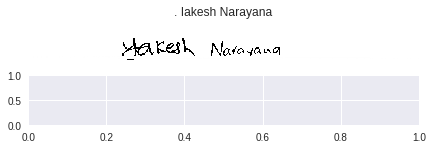

[[ 0.26465743 -0.03373647  0.02413196  0.11410729]
 [ 0.22628078  0.23314733  0.8330847   0.41671195]
 [ 0.22628078  0.64985928  0.8330847   0.41671195]]
[[255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 ...
 [255 255 255 ... 254 254 254]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]]


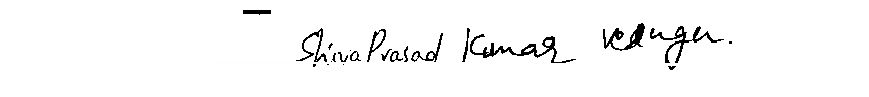

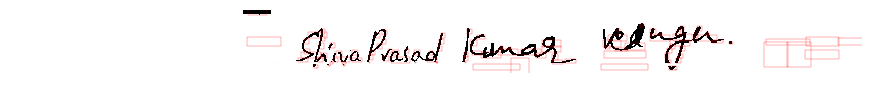

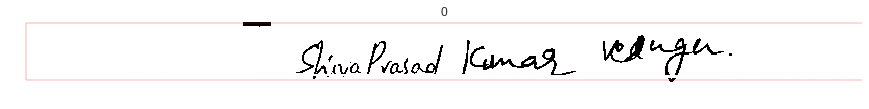

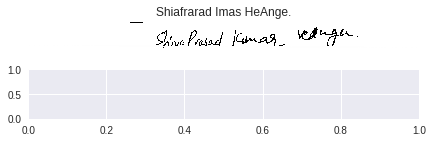

[[0.01487824 0.40814027 0.81260138 0.50311845]
 [0.03220401 0.56759071 1.02159646 0.30641837]
 [0.01619384 0.85598951 0.7789948  0.09565009]]
[[255 255 255 ... 254 254 254]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 ...
 [254 254 254 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]]


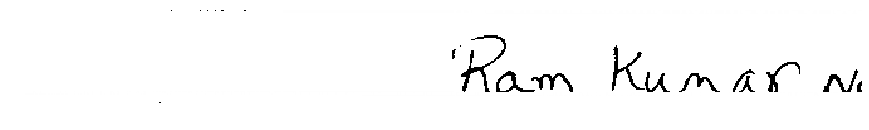

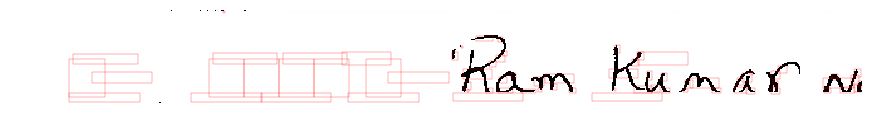

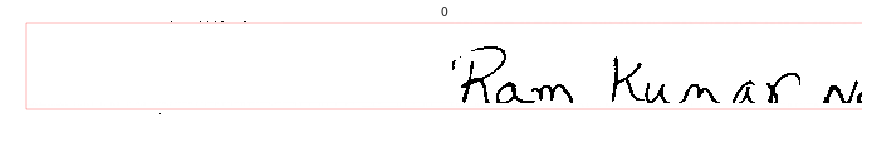

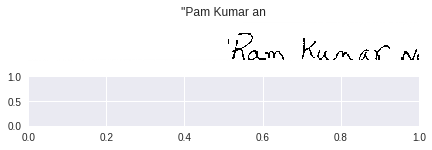

[[-0.00224819  0.2315726   1.01034804  0.89194703]]
[[255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 ...
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]]


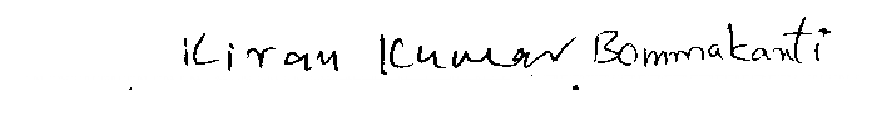

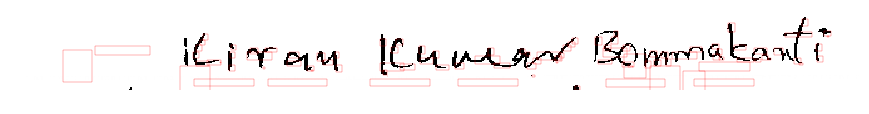

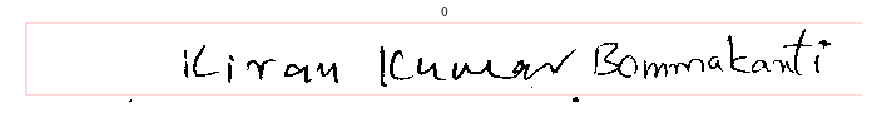

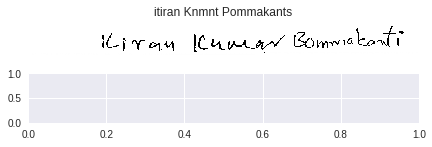

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


FloatingPointError: ignored

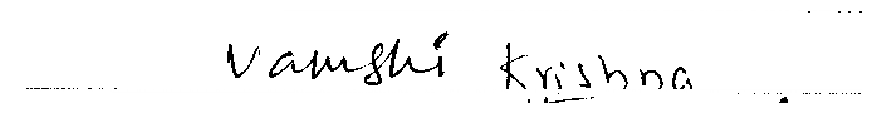

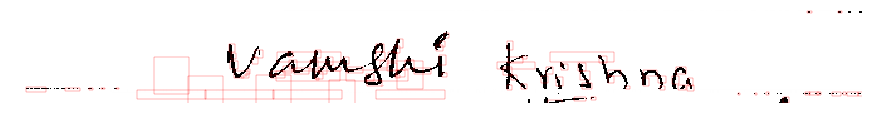

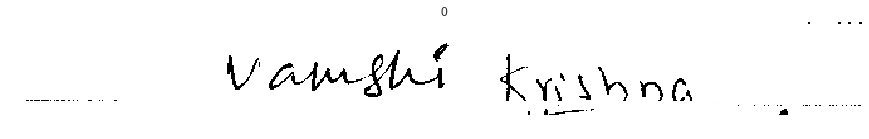

In [0]:
#import cv2
all_file = glob.glob('FYP/Automated cheque processing/dataset/name/'+'*.tif')
count = 0
for single_file in all_file:
  count +=1
  if count < 30 :
    continue
  
  im = cv2.imread(single_file, cv2.IMREAD_GRAYSCALE)
  img_arr = np.asarray(im)
  test_ds = img_arr
  ##print(test_ds)
  figs_to_plot = 1
  images = []

  for i in range(0, figs_to_plot):
      n = int(random.random()*1)
      image= test_ds
      images.append(image)
  images = image
  #print(image)
  #print(images)
  #print(image.shape)
  image = 255 - image
  #print(image)
  fig, axs = plt.subplots(1, 1, figsize=(15, 20))
  #for i, image in enumerate(images):
  y, x = 0,0
  axs.imshow(image, cmap='Greys_r')
  axs.axis('off')
  word_segmentation_net = WordSegmentationNet(2, ctx=ctx)
  word_segmentation_net.load_parameters("models/word_segmentation2.params")
  min_c = 0.1
  overlap_thres = 0.1
  topk = 600
  paragraph_segmented_images = []
  paragraph_segmented_images.append(image)

  # fig, axs = plt.subplots(int(len(paragraph_segmented_images)/2), 2, 
  #                         figsize=(15, 5 * int(len(paragraph_segmented_images)/2)))
  # predicted_words_bbs_array = []

  # for i, paragraph_segmented_image in enumerate(paragraph_segmented_images):
  #     s_y, s_x = int(i/2), int(i%2)

  #     predicted_bb = predict_bounding_boxes(
  #         word_segmentation_net, paragraph_segmented_image, min_c, overlap_thres, topk, ctx)

  #     predicted_words_bbs_array.append(predicted_bb)

  #     axs[s_y, s_x].imshow(paragraph_segmented_image, cmap='Greys_r')
  #     for j in range(predicted_bb.shape[0]):     
  #         (x, y, w, h) = predicted_bb[j]
  #         image_h, image_w = paragraph_segmented_image.shape[-2:]
  #         (x, y, w, h) = (x * image_w, y * image_h, w * image_w, h * image_h)
  #         rect = patches.Rectangle((x, y), w, h, fill=False, color="r")
  #         axs[s_y, s_x].add_patch(rect)
  #         axs[s_y, s_x].axis('off')

  fig, axs = plt.subplots(1, 1, figsize=(15, 10 ))
  predicted_words_bbs_array = []
  paragraph_segmented_image = image #paragraph_segmented_images[0]
  predicted_bb = predict_bounding_boxes(
           word_segmentation_net, paragraph_segmented_image, min_c, overlap_thres, topk, ctx)
  predicted_words_bbs_array.append(predicted_bb)
  axs.imshow(paragraph_segmented_image, cmap='Greys_r')
  for j in range(predicted_bb.shape[0]):     
          (x, y, w, h) = predicted_bb[j]
          image_h, image_w = paragraph_segmented_image.shape[-2:]
          (x, y, w, h) = (x * image_w, y * image_h, w * image_w, h * image_h)
          rect = patches.Rectangle((x, y), w, h, fill=False, color="r")
          axs.add_patch(rect)
          axs.axis('off')
  line_images_array = []
  #fig, axs = plt.subplots(int(len(paragraph_segmented_images)/2), 2, 
                          #figsize=(15, 9 * int(len(paragraph_segmented_images)/2)))

  fig, axs = plt.subplots(1, 1, figsize=(15, 18))


  # for i, paragraph_segmented_image in enumerate(paragraph_segmented_images):
  #     s_y, s_x = int(i/2), int(i%2)
  #     axs[s_y, s_x].imshow(paragraph_segmented_image, cmap='Greys_r')
  #     axs[s_y, s_x].axis('off')
  #     axs[s_y, s_x].set_title("{}".format(i))

  #     predicted_bbs = predicted_words_bbs_array[i]
  #     line_bbs = sort_bbs_line_by_line(predicted_bbs, y_overlap=0.4)
  #     line_images = crop_line_images(paragraph_segmented_image, line_bbs)
  #     line_images_array.append(line_images)

  #     for line_bb in line_bbs:
  #         (x, y, w, h) = line_bb
  #         image_h, image_w = paragraph_segmented_image.shape[-2:]
  #         (x, y, w, h) = (x * image_w, y * image_h, w * image_w, h * image_h)

  #         rect = patches.Rectangle((x, y), w, h, fill=False, color="r")
  #         axs[s_y, s_x].add_patch(rect)

  paragraph_segmented_image = paragraph_segmented_images[0]
  axs.imshow(paragraph_segmented_image, cmap='Greys_r')
  axs.axis('off')
  axs.set_title("{}".format(i))
  predicted_bbs = predicted_words_bbs_array[0]
  line_bbs = sort_bbs_line_by_line(predicted_bbs, y_overlap=0.4)
  print(line_bbs)
  line_bbs = [[0.0001,0.01,1.0,0.9]]
  line_images = crop_line_images(paragraph_segmented_image, line_bbs)
  line_images_array.append(line_images)

  for line_bb in line_bbs:
      (x, y, w, h) = line_bb
      image_h, image_w = paragraph_segmented_image.shape[-2:]
      (x, y, w, h) = (x * image_w, y * image_h, w * image_w, h * image_h)

      rect = patches.Rectangle((x, y), w, h, fill=False, color="r")
      axs.add_patch(rect)

  handwriting_line_recognition_net = HandwritingRecognitionNet(rnn_hidden_states=512,
                                                               rnn_layers=2, ctx=ctx, max_seq_len=160)
  handwriting_line_recognition_net.load_parameters("models/handwriting_line_sl_160_a_512_o_2.params")
  line_image_size = (60, 800)
  character_probs = []
  for line_images in line_images_array:
      form_character_prob = []
      for i, line_image in enumerate(line_images):
          line_image = handwriting_recognition_transform(line_image, line_image_size)
          line_character_prob = handwriting_line_recognition_net(line_image.as_in_context(ctx))
          form_character_prob.append(line_character_prob)
      character_probs.append(form_character_prob)
  from utils.CTCDecoder.BeamSearch import ctcBeamSearch
  from utils.CTCDecoder.LanguageModel import LanguageModel
  def get_arg_max(prob):
      '''
      The greedy algorithm convert the output of the handwriting recognition network
      into strings.
      '''
      arg_max = prob.topk(axis=2).asnumpy()
      return decoder_handwriting(arg_max)[0]
  def get_beam_search(prob, width=20, k=4):
      possibilities = ctcBeamSearch(prob.softmax()[0].asnumpy(), alphabet_encoding, None, width, k)
      return possibilities[0]
  def get_beam_search_with_lm(prob, width=20, k=4):
      lm = LanguageModel('dataset/alicewonder.txt', alphabet_encoding)
      possibilities = ctcBeamSearch(prob.softmax()[0].asnumpy(), alphabet_encoding, lm, width, k)
      return possibilities[0]
  for i, form_character_probs in enumerate(character_probs):
      fig, axs = plt.subplots(len(form_character_probs) + 1, 
                              figsize=(7, int(1 + 1.2 * len(form_character_probs))))
      for j, line_character_probs in enumerate(form_character_probs):
          decoded_line = get_arg_max(line_character_probs)
          line_image = line_images_array[i][j]
          print(line_image)
          axs[j].imshow(line_image.squeeze(), cmap='Greys_r')            
          axs[j].imshow(line_image.squeeze(), cmap='Greys_r')
          axs[j].set_title("{}".format(decoded_line))
          axs[j].axis('off')
      #axs[-1].imshow(np.zeros(shape=line_image_size), cmap='Greys_r')
      #axs[-1].axis('off')
  plt.show()